# **Packages**  

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error as MSE

# **Downloading the samples**

In [2]:
with open("400_samples_for_model.pkl","rb") as f:
    amazon_samples400 = pickle.load(f)

print(amazon_samples400.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 67 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Agent_Age                          400 non-null    float64
 1   Agent_Rating                       400 non-null    float64
 2   Drop_Latitude                      400 non-null    float64
 3   Drop_Longitude                     400 non-null    float64
 4   Distance_Store_Drop_km             400 non-null    float64
 5   abs_Store_Latitude                 400 non-null    float64
 6   abs_Store_Longitude                400 non-null    float64
 7   Order_weekday                      400 non-null    float64
 8   Order_Time_hour                    400 non-null    float64
 9   Pickup_hour                        400 non-null    float64
 10  Delivery_Time                      400 non-null    int64  
 11  Young_vs_Older_Agents              400 non-null    int32  

# **Splitting data**

In [3]:
X= amazon_samples400.drop("Delivery_Time", axis=1)
y=amazon_samples400["Delivery_Time"]

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1984)


# **Finding the best model**  


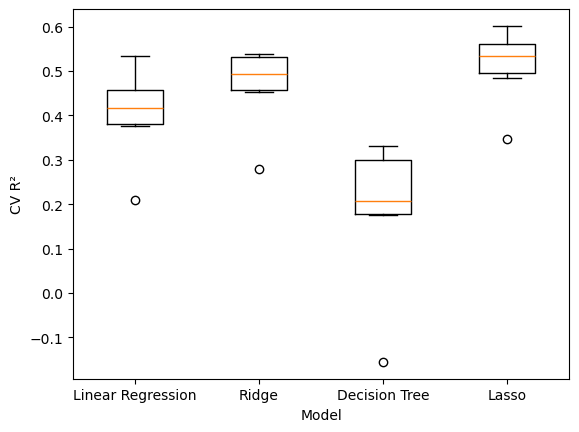

In [5]:
LinearReg = LinearRegression()
DecTree = DecisionTreeRegressor(max_depth=33, min_samples_leaf=0.05, max_features="sqrt", random_state=2013)
ridge = Ridge(alpha=0.1)
lasso = Lasso(alpha = 0.1)

models = {"Linear Regression":LinearReg, "Ridge":ridge, "Decision Tree":DecTree, "Lasso":lasso}

from modules import visu_cv_score

visu_cv_score(models,X_train,y_train)


In [6]:
from modules import rmse_regression_models

rmse_regression_models(models,X_train,y_train,X_test,y_test)

Linear Regression Test set rmse: 39.46887034200775
Ridge Test set rmse: 39.51343421424932
Decision Tree Test set rmse: 49.51442762201243
Lasso Test set rmse: 38.53096960784252


Although none of them are at this stage great, Lasso would be the best algorithm to tune.

# **Lasso hyperparamater tuning**

# **Model with no cities**

In [7]:
with open("400samples_noCities.pkl","rb") as f:
    samples_noCities = pickle.load(f)

In [8]:
samples_noCities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Agent_Age               400 non-null    float64
 1   Agent_Rating            400 non-null    float64
 2   Drop_Latitude           400 non-null    float64
 3   Drop_Longitude          400 non-null    float64
 4   Distance_Store_Drop_km  400 non-null    float64
 5   abs_Store_Latitude      400 non-null    float64
 6   abs_Store_Longitude     400 non-null    float64
 7   Order_weekday           400 non-null    float64
 8   Order_Time_hour         400 non-null    float64
 9   Pickup_hour             400 non-null    float64
 10  Delivery_Time           400 non-null    int64  
 11  Young_vs_Older_Agents   400 non-null    int32  
 12  Grocery_vs_not          400 non-null    int32  
 13  Weather_Cloudy          400 non-null    bool   
 14  Weather_Fog             400 non-null    bo

In [9]:
numerical_features = samples_noCities[["Agent_Age","Agent_Rating","Distance_Store_Drop_km","Order_weekday",\
                                       "Order_Time_hour","Pickup_hour","Drop_Latitude","Drop_Longitude",\
                                        "abs_Store_Latitude","abs_Store_Longitude"]]

print(numerical_features.corr())


                        Agent_Age  Agent_Rating  Distance_Store_Drop_km  \
Agent_Age                1.000000     -0.091737                0.003242   
Agent_Rating            -0.091737      1.000000               -0.087349   
Distance_Store_Drop_km   0.003242     -0.087349                1.000000   
Order_weekday            0.012985     -0.013691                0.107052   
Order_Time_hour          0.050347     -0.092842                0.566868   
Pickup_hour              0.039450     -0.090907                0.465678   
Drop_Latitude            0.033723      0.059967               -0.030055   
Drop_Longitude           0.045485      0.042194                0.000979   
abs_Store_Latitude       0.033695      0.060523               -0.036534   
abs_Store_Longitude      0.045440      0.043125               -0.009843   

                        Order_weekday  Order_Time_hour  Pickup_hour  \
Agent_Age                    0.012985         0.050347     0.039450   
Agent_Rating                -0.0

In [10]:
samples_noCities = samples_noCities.drop(["Order_Time_hour","abs_Store_Latitude","abs_Store_Longitude","Category_Grocery","Agent_Age"], axis=1)

In [11]:
X_noC = samples_noCities.drop("Delivery_Time", axis=1)
y_noC = samples_noCities["Delivery_Time"]

X_noC_train,X_noC_test,y_noC_train,y_noC_test = train_test_split(X_noC,y_noC,test_size=0.25,random_state=1984)


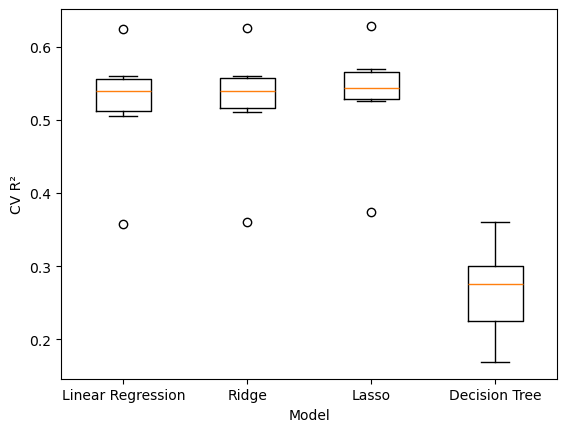

In [12]:
decTreeC = DecisionTreeRegressor(max_depth=19, min_samples_leaf=0.05, max_features="sqrt", random_state=1984)
new_models = {"Linear Regression":LinearReg, "Ridge":ridge, "Lasso":lasso, "Decision Tree":decTreeC}
visu_cv_score(new_models,X_noC_train,y_noC_train)

In [13]:
rmse_regression_models(new_models,X_noC_train,y_noC_train,X_noC_test,y_noC_test)

Linear Regression Test set rmse: 37.412678965729945
Ridge Test set rmse: 37.411947191683886
Lasso Test set rmse: 37.13151972424974
Decision Tree Test set rmse: 52.08390779160516


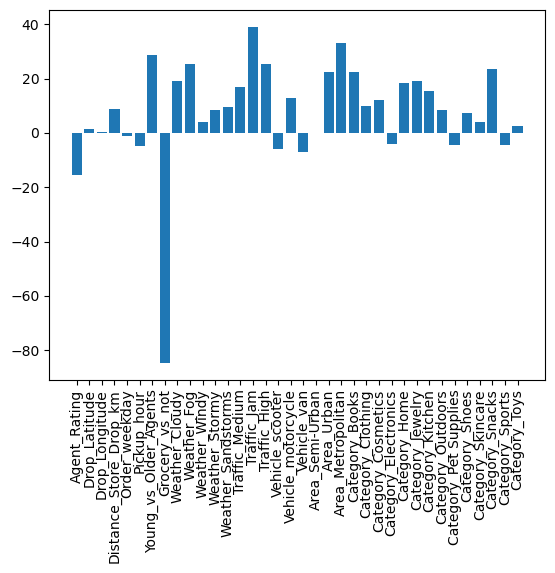

In [14]:
LinearReg.fit(X_noC_train,y_noC_train)

coef = LinearReg.coef_
columns = X_noC.columns
plt.bar(x=columns, height=coef)
plt.xticks(rotation=90)
plt.show()

# **Hyperparameter tuning of Ridge**

In [15]:
scores=[]
alphas_list = np.linspace(0,1,num=20)
for alpha in alphas_list:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_noC_train,y_noC_train)
    ridge_pred = ridge.predict(X_noC_test)
    scores.append(MSE(y_noC_test,ridge_pred)**(1/2))

print(scores)

[37.44606329442389, 37.41187544076239, 37.411999652167, 37.41299301099327, 37.414801692300095, 37.41737615879549, 37.42067074010264, 37.424643260118664, 37.42925470615789, 37.43446893454226, 37.44025240808753, 37.44657396158057, 37.45340459188122, 37.46071726973525, 37.468486770768514, 37.476689523459136, 37.485303472165135, 37.49430795352507, 37.50368358475724, 37.51341216256231]


In [16]:
ridge_scores_alphas = pd.DataFrame(scores, index=alphas_list)
print(ridge_scores_alphas)

                  0
0.000000  37.446063
0.052632  37.411875
0.105263  37.412000
0.157895  37.412993
0.210526  37.414802
0.263158  37.417376
0.315789  37.420671
0.368421  37.424643
0.421053  37.429255
0.473684  37.434469
0.526316  37.440252
0.578947  37.446574
0.631579  37.453405
0.684211  37.460717
0.736842  37.468487
0.789474  37.476690
0.842105  37.485303
0.894737  37.494308
0.947368  37.503684
1.000000  37.513412


In [17]:
best_alpha = 0.052632
best_regr = Ridge(alpha=best_alpha)
best_regr.fit(X_noC_train,y_noC_train)

Ridge(alpha=0.052632)

37.41187543812667
29.270475368712642


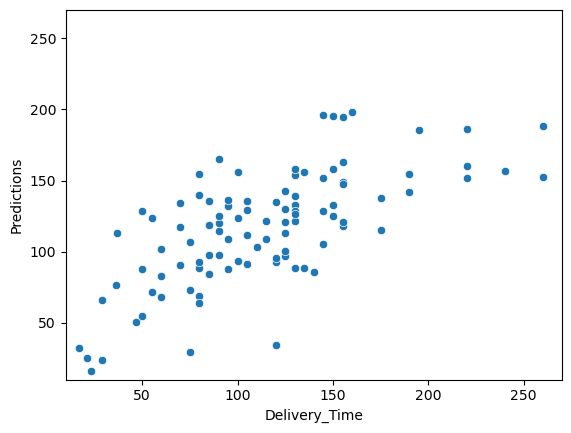

In [18]:
y_predict = best_regr.predict(X_noC_test)
print(MSE(y_noC_test,y_predict) **(1/2))
from sklearn.metrics import mean_absolute_error as mae
print(mae(y_noC_test,y_predict))
sns.scatterplot(x=y_noC_test, y=y_predict)
plt.xlim(10,270)
plt.ylim(10,270)
plt.ylabel("Predictions")
plt.show()

In [19]:
comparison = pd.DataFrame({"Delivery_Time":y_noC_test, "Predictions_Del_Time":y_predict})
print(comparison.corr())

                      Delivery_Time  Predictions_Del_Time
Delivery_Time              1.000000              0.698513
Predictions_Del_Time       0.698513              1.000000


In [20]:
comparison.head(20)

,Delivery_Time,Predictions_Del_Time
254,150,195.762995
82,90,119.979874
309,90,165.386407
341,80,139.573470
262,130,138.945998
53,95,108.864368
145,60,102.008440
113,155,163.173397
173,95,132.099286
269,21,25.305851


# **Linear Regression**

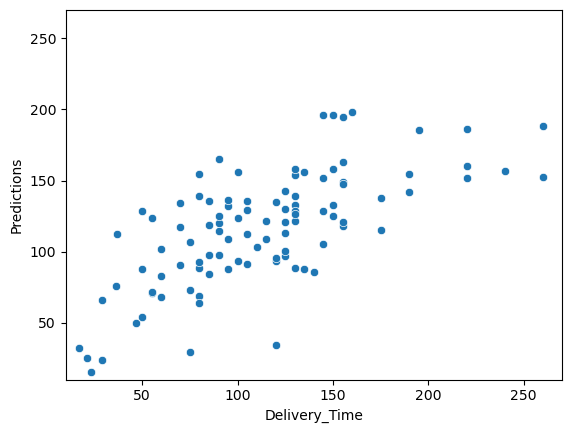

In [21]:
LinearReg.fit(X_noC_train,y_noC_train)
LinReg_predict = LinearReg.predict(X_noC_test)

sns.scatterplot(x=y_noC_test, y=LinReg_predict)
plt.xlim(10,270)
plt.ylim(10,270)
plt.ylabel("Predictions")
plt.show()

In [22]:
comparison_Lin = pd.DataFrame({"Delivery_Time":y_noC_test, "Predictions_Del_Time":LinReg_predict})
print(comparison_Lin.corr())

                      Delivery_Time  Predictions_Del_Time
Delivery_Time              1.000000              0.698745
Predictions_Del_Time       0.698745              1.000000


In [23]:
comparison_Lin.head(10)

,Delivery_Time,Predictions_Del_Time
254,150,195.857890
82,90,119.965856
309,90,165.394901
341,80,139.471363
262,130,138.967048
53,95,108.857085
145,60,102.040883
113,155,163.123788
173,95,132.107778
269,21,24.954164
